In [8]:
# Chest X-ray Image Classification

In [22]:
#Load Library
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import RMSprop
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
from sklearn.utils import shuffle




In [11]:
metadata = pd.read_csv('Chest_xray_Corona_Metadata.csv')
summary = pd.read_csv('Chest_xray_Corona_dataset_Summary.csv')

metadata.sample(5)

,Unnamed: 0,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category
1969,1969,person1318_virus_2274.jpeg,Pnemonia,TRAIN,NaN,Virus
4878,4878,person7_bacteria_24.jpeg,Pnemonia,TRAIN,NaN,bacteria
1533,1533,person1078_virus_1788.jpeg,Pnemonia,TRAIN,NaN,Virus
5205,5205,person894_virus_1546.jpeg,Pnemonia,TRAIN,NaN,Virus
494,494,IM-0656-0001.jpeg,Normal,TRAIN,NaN,NaN


In [20]:
train_data = metadata[metadata['Dataset_type'] == 'TRAIN']
test_data = metadata[metadata['Dataset_type'] == 'TEST']
assert train_data.shape[0] + test_data.shape[0] == metadata.shape[0]
print(train_data.shape)
print(test_data.shape)
print(metadata.shape)
test_data.sample(5)

(5286, 6)
(624, 6)
(5910, 6)


,Unnamed: 0,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category
5293,5316,IM-0011-0001-0002.jpeg,Normal,TEST,NaN,NaN
5331,5354,IM-0099-0001.jpeg,Normal,TEST,NaN,NaN
5470,5493,NORMAL2-IM-0120-0001.jpeg,Normal,TEST,NaN,NaN
5434,5457,NORMAL2-IM-0246-0001.jpeg,Normal,TEST,NaN,NaN
5775,5798,person78_bacteria_384.jpeg,Pnemonia,TEST,NaN,bacteria


In [25]:
# Generate the final train data from original train data with conditions refered from EDA inference
final_train_data = train_data[(train_data['Label'] == 'Normal') | 
                              ((train_data['Label'] == 'Pnemonia') & (train_data['Label_2_Virus_category'] == 'COVID-19'))]


# Create a target attribute where value = positive if 'Pnemonia + COVID-19' or value = negative if 'Normal'
final_train_data['target'] = ['negative' if holder == 'Normal' else 'positive' for holder in final_train_data['Label']]

final_train_data = shuffle(final_train_data, random_state=1)

final_validation_data = final_train_data.iloc[1000:, :]
final_train_data = final_train_data.iloc[:1000, :]

print(final_train_data.shape)
final_train_data.sample(30)

(1000, 7)


c:\users\bayua\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


,Unnamed: 0,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category,target
5259,5273,5931B64A-7B97-485D-BE60-3F1EA76BC4F0.jpeg,Pnemonia,TRAIN,COVID-19,Virus,positive
1047,1047,NORMAL2-IM-0983-0001.jpeg,Normal,TRAIN,NaN,NaN,negative
490,490,IM-0660-0001-0001.jpeg,Normal,TRAIN,NaN,NaN,negative
578,578,IM-0703-0001.jpeg,Normal,TRAIN,NaN,NaN,negative
754,754,NORMAL2-IM-0587-0001.jpeg,Normal,TRAIN,NaN,NaN,negative
711,711,NORMAL2-IM-0491-0001.jpeg,Normal,TRAIN,NaN,NaN,negative
783,783,NORMAL2-IM-0629-0001.jpeg,Normal,TRAIN,NaN,NaN,negative
5272,5291,171CB377-62FF-4B76-906C-F3787A01CB2E.jpeg,Pnemonia,TRAIN,COVID-19,Virus,positive
94,94,IM-0262-0001.jpeg,Normal,TRAIN,NaN,NaN,negative
482,482,IM-0666-0001-0001.jpeg,Normal,TRAIN,NaN,NaN,negative


In [44]:
#Load file & Create Model
train_data_dir = 'Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train'
test_data_dir = 'Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/test'

epochs = 5

model = tf.keras.models.Sequential([
# YOUR CODE HERE
    tf.keras.layers.Conv2D(32, (3,3), activation='relu',input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPool2D(2,2),
    
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy','TruePositives','TrueNegatives','FalsePositives','FalseNegatives'])

#os.listdir(validation_data_dir)
print(train_data_dir)
print(validation_data_dir)
model.summary()

Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train
Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/test
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 52, 52, 128)       73856     
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 26, 26, 128)       

In [38]:
# this is the augmentation configuration we will use for training
train_image_generator = ImageDataGenerator(
    rescale=1./255,
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=90,
    width_shift_range=0.15,
    height_shift_range=0.15,
    horizontal_flip=True,
    zoom_range=[0.9, 1.25],
    brightness_range=[0.5, 1.5]
)

test_image_generator = ImageDataGenerator(
    rescale=1./255
)

train_generator = train_image_generator.flow_from_dataframe(
    dataframe=final_train_data,
    directory=train_data_dir,
    x_col='X_ray_image_name',
    y_col='target',
    target_size=(224, 224),
    batch_size=8,
    seed=2020,
    shuffle=True,
    class_mode='binary'
)

validation_generator = train_image_generator.flow_from_dataframe(
    dataframe=final_validation_data,
    directory=train_data_dir,
    x_col='X_ray_image_name',
    y_col='target',
    target_size=(224, 224),
    batch_size=8,
    seed=2020,
    shuffle=True,
    class_mode='binary'
)

test_generator = test_image_generator.flow_from_dataframe(
    dataframe=test_data,
    directory=test_data_dir,
    x_col='X_ray_image_name',
    target_size=(224, 224),
    shuffle=False,
    batch_size=16,
    class_mode=None
)

history = model.fit_generator(
    train_generator,
    steps_per_epoch=20,
    epochs=epochs,
    validation_data=validation_generator,
    verbose = 1,
    validation_steps=3)

Found 1000 validated image filenames belonging to 2 classes.
Found 400 validated image filenames belonging to 2 classes.
Found 624 validated image filenames.
Epoch 1/5


c:\users\bayua\appdata\local\programs\python\python37\lib\site-packages\keras_preprocessing\image\image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
c:\users\bayua\appdata\local\programs\python\python37\lib\site-packages\keras_preprocessing\image\image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


 1/20 [>.............................] - ETA: 58s - loss: 0.6746 - accuracy: 0.7500 - TruePositives: 0.0000e+00 - TrueNegatives: 6.0000 - FalsePositives: 1.0000 - FalseNegatives: 1.0000

c:\users\bayua\appdata\local\programs\python\python37\lib\site-packages\keras_preprocessing\image\image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
c:\users\bayua\appdata\local\programs\python\python37\lib\site-packages\keras_preprocessing\image\image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


 2/20 [==>...........................] - ETA: 45s - loss: 1.3013 - accuracy: 0.8125 - TruePositives: 0.0000e+00 - TrueNegatives: 13.0000 - FalsePositives: 1.0000 - FalseNegatives: 2.0000

c:\users\bayua\appdata\local\programs\python\python37\lib\site-packages\keras_preprocessing\image\image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
c:\users\bayua\appdata\local\programs\python\python37\lib\site-packages\keras_preprocessing\image\image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


 3/20 [===>..........................] - ETA: 39s - loss: 1.5103 - accuracy: 0.8333 - TruePositives: 0.0000e+00 - TrueNegatives: 20.0000 - FalsePositives: 1.0000 - FalseNegatives: 3.0000

c:\users\bayua\appdata\local\programs\python\python37\lib\site-packages\keras_preprocessing\image\image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
c:\users\bayua\appdata\local\programs\python\python37\lib\site-packages\keras_preprocessing\image\image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


 4/20 [=====>........................] - ETA: 35s - loss: 1.1327 - accuracy: 0.8750 - TruePositives: 0.0000e+00 - TrueNegatives: 28.0000 - FalsePositives: 1.0000 - FalseNegatives: 3.0000

c:\users\bayua\appdata\local\programs\python\python37\lib\site-packages\keras_preprocessing\image\image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
c:\users\bayua\appdata\local\programs\python\python37\lib\site-packages\keras_preprocessing\image\image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


 5/20 [======>.......................] - ETA: 32s - loss: 0.9062 - accuracy: 0.9000 - TruePositives: 0.0000e+00 - TrueNegatives: 36.0000 - FalsePositives: 1.0000 - FalseNegatives: 3.0000

c:\users\bayua\appdata\local\programs\python\python37\lib\site-packages\keras_preprocessing\image\image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
c:\users\bayua\appdata\local\programs\python\python37\lib\site-packages\keras_preprocessing\image\image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


 6/20 [========>.....................] - ETA: 30s - loss: 0.7551 - accuracy: 0.9167 - TruePositives: 0.0000e+00 - TrueNegatives: 44.0000 - FalsePositives: 1.0000 - FalseNegatives: 3.0000

c:\users\bayua\appdata\local\programs\python\python37\lib\site-packages\keras_preprocessing\image\image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
c:\users\bayua\appdata\local\programs\python\python37\lib\site-packages\keras_preprocessing\image\image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


 7/20 [=========>....................] - ETA: 27s - loss: 0.9227 - accuracy: 0.9107 - TruePositives: 0.0000e+00 - TrueNegatives: 51.0000 - FalsePositives: 1.0000 - FalseNegatives: 4.0000

c:\users\bayua\appdata\local\programs\python\python37\lib\site-packages\keras_preprocessing\image\image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
c:\users\bayua\appdata\local\programs\python\python37\lib\site-packages\keras_preprocessing\image\image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


 8/20 [===========>..................] - ETA: 25s - loss: 0.8074 - accuracy: 0.9219 - TruePositives: 0.0000e+00 - TrueNegatives: 59.0000 - FalsePositives: 1.0000 - FalseNegatives: 4.0000

c:\users\bayua\appdata\local\programs\python\python37\lib\site-packages\keras_preprocessing\image\image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
c:\users\bayua\appdata\local\programs\python\python37\lib\site-packages\keras_preprocessing\image\image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


 9/20 [============>.................] - ETA: 23s - loss: 0.7177 - accuracy: 0.9306 - TruePositives: 0.0000e+00 - TrueNegatives: 67.0000 - FalsePositives: 1.0000 - FalseNegatives: 4.0000

c:\users\bayua\appdata\local\programs\python\python37\lib\site-packages\keras_preprocessing\image\image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
c:\users\bayua\appdata\local\programs\python\python37\lib\site-packages\keras_preprocessing\image\image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


10/20 [==============>...............] - ETA: 20s - loss: 0.6459 - accuracy: 0.9375 - TruePositives: 0.0000e+00 - TrueNegatives: 75.0000 - FalsePositives: 1.0000 - FalseNegatives: 4.0000

c:\users\bayua\appdata\local\programs\python\python37\lib\site-packages\keras_preprocessing\image\image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
c:\users\bayua\appdata\local\programs\python\python37\lib\site-packages\keras_preprocessing\image\image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


11/20 [===============>..............] - ETA: 18s - loss: 0.5872 - accuracy: 0.9432 - TruePositives: 0.0000e+00 - TrueNegatives: 83.0000 - FalsePositives: 1.0000 - FalseNegatives: 4.0000

c:\users\bayua\appdata\local\programs\python\python37\lib\site-packages\keras_preprocessing\image\image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
c:\users\bayua\appdata\local\programs\python\python37\lib\site-packages\keras_preprocessing\image\image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


12/20 [=================>............] - ETA: 16s - loss: 0.5382 - accuracy: 0.9479 - TruePositives: 0.0000e+00 - TrueNegatives: 91.0000 - FalsePositives: 1.0000 - FalseNegatives: 4.0000

c:\users\bayua\appdata\local\programs\python\python37\lib\site-packages\keras_preprocessing\image\image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
c:\users\bayua\appdata\local\programs\python\python37\lib\site-packages\keras_preprocessing\image\image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


13/20 [==================>...........] - ETA: 14s - loss: 0.4968 - accuracy: 0.9519 - TruePositives: 0.0000e+00 - TrueNegatives: 99.0000 - FalsePositives: 1.0000 - FalseNegatives: 4.0000

c:\users\bayua\appdata\local\programs\python\python37\lib\site-packages\keras_preprocessing\image\image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
c:\users\bayua\appdata\local\programs\python\python37\lib\site-packages\keras_preprocessing\image\image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


14/20 [====================>.........] - ETA: 12s - loss: 0.4614 - accuracy: 0.9554 - TruePositives: 0.0000e+00 - TrueNegatives: 107.0000 - FalsePositives: 1.0000 - FalseNegatives: 4.0000

c:\users\bayua\appdata\local\programs\python\python37\lib\site-packages\keras_preprocessing\image\image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
c:\users\bayua\appdata\local\programs\python\python37\lib\site-packages\keras_preprocessing\image\image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


15/20 [=====================>........] - ETA: 10s - loss: 0.4306 - accuracy: 0.9583 - TruePositives: 0.0000e+00 - TrueNegatives: 115.0000 - FalsePositives: 1.0000 - FalseNegatives: 4.0000

c:\users\bayua\appdata\local\programs\python\python37\lib\site-packages\keras_preprocessing\image\image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
c:\users\bayua\appdata\local\programs\python\python37\lib\site-packages\keras_preprocessing\image\image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


16/20 [=======================>......] - ETA: 8s - loss: 0.4037 - accuracy: 0.9609 - TruePositives: 0.0000e+00 - TrueNegatives: 123.0000 - FalsePositives: 1.0000 - FalseNegatives: 4.0000 

c:\users\bayua\appdata\local\programs\python\python37\lib\site-packages\keras_preprocessing\image\image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
c:\users\bayua\appdata\local\programs\python\python37\lib\site-packages\keras_preprocessing\image\image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


17/20 [========================>.....] - ETA: 6s - loss: 0.4934 - accuracy: 0.9559 - TruePositives: 0.0000e+00 - TrueNegatives: 130.0000 - FalsePositives: 1.0000 - FalseNegatives: 5.0000

c:\users\bayua\appdata\local\programs\python\python37\lib\site-packages\keras_preprocessing\image\image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
c:\users\bayua\appdata\local\programs\python\python37\lib\site-packages\keras_preprocessing\image\image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


18/20 [==========================>...] - ETA: 4s - loss: 0.4659 - accuracy: 0.9583 - TruePositives: 0.0000e+00 - TrueNegatives: 138.0000 - FalsePositives: 1.0000 - FalseNegatives: 5.0000

c:\users\bayua\appdata\local\programs\python\python37\lib\site-packages\keras_preprocessing\image\image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
c:\users\bayua\appdata\local\programs\python\python37\lib\site-packages\keras_preprocessing\image\image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


19/20 [===========================>..] - ETA: 2s - loss: 0.4414 - accuracy: 0.9605 - TruePositives: 0.0000e+00 - TrueNegatives: 146.0000 - FalsePositives: 1.0000 - FalseNegatives: 5.0000

c:\users\bayua\appdata\local\programs\python\python37\lib\site-packages\keras_preprocessing\image\image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
c:\users\bayua\appdata\local\programs\python\python37\lib\site-packages\keras_preprocessing\image\image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


20/20 [==============================] - 44s 2s/step - loss: 0.4194 - accuracy: 0.9625 - TruePositives: 0.0000e+00 - TrueNegatives: 154.0000 - FalsePositives: 1.0000 - FalseNegatives: 5.0000 - val_loss: 1.2854 - val_accuracy: 0.9167 - val_TruePositives: 0.0000e+00 - val_TrueNegatives: 22.0000 - val_FalsePositives: 0.0000e+00 - val_FalseNegatives: 2.0000
Epoch 2/5


c:\users\bayua\appdata\local\programs\python\python37\lib\site-packages\keras_preprocessing\image\image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
c:\users\bayua\appdata\local\programs\python\python37\lib\site-packages\keras_preprocessing\image\image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


 1/20 [>.............................] - ETA: 36s - loss: 0.0000e+00 - accuracy: 1.0000 - TruePositives: 0.0000e+00 - TrueNegatives: 8.0000 - FalsePositives: 0.0000e+00 - FalseNegatives: 0.0000e+00

c:\users\bayua\appdata\local\programs\python\python37\lib\site-packages\keras_preprocessing\image\image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
c:\users\bayua\appdata\local\programs\python\python37\lib\site-packages\keras_preprocessing\image\image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


 2/20 [==>...........................] - ETA: 34s - loss: 0.0000e+00 - accuracy: 1.0000 - TruePositives: 0.0000e+00 - TrueNegatives: 16.0000 - FalsePositives: 0.0000e+00 - FalseNegatives: 0.0000e+00

c:\users\bayua\appdata\local\programs\python\python37\lib\site-packages\keras_preprocessing\image\image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
c:\users\bayua\appdata\local\programs\python\python37\lib\site-packages\keras_preprocessing\image\image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


 3/20 [===>..........................] - ETA: 32s - loss: 0.0000e+00 - accuracy: 1.0000 - TruePositives: 0.0000e+00 - TrueNegatives: 24.0000 - FalsePositives: 0.0000e+00 - FalseNegatives: 0.0000e+00

c:\users\bayua\appdata\local\programs\python\python37\lib\site-packages\keras_preprocessing\image\image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
c:\users\bayua\appdata\local\programs\python\python37\lib\site-packages\keras_preprocessing\image\image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


 4/20 [=====>........................] - ETA: 30s - loss: 0.0000e+00 - accuracy: 1.0000 - TruePositives: 0.0000e+00 - TrueNegatives: 32.0000 - FalsePositives: 0.0000e+00 - FalseNegatives: 0.0000e+00

c:\users\bayua\appdata\local\programs\python\python37\lib\site-packages\keras_preprocessing\image\image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
c:\users\bayua\appdata\local\programs\python\python37\lib\site-packages\keras_preprocessing\image\image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


 5/20 [======>.......................] - ETA: 28s - loss: 0.0000e+00 - accuracy: 1.0000 - TruePositives: 0.0000e+00 - TrueNegatives: 40.0000 - FalsePositives: 0.0000e+00 - FalseNegatives: 0.0000e+00

c:\users\bayua\appdata\local\programs\python\python37\lib\site-packages\keras_preprocessing\image\image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
c:\users\bayua\appdata\local\programs\python\python37\lib\site-packages\keras_preprocessing\image\image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


 6/20 [========>.....................] - ETA: 26s - loss: 0.0000e+00 - accuracy: 1.0000 - TruePositives: 0.0000e+00 - TrueNegatives: 48.0000 - FalsePositives: 0.0000e+00 - FalseNegatives: 0.0000e+00

c:\users\bayua\appdata\local\programs\python\python37\lib\site-packages\keras_preprocessing\image\image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
c:\users\bayua\appdata\local\programs\python\python37\lib\site-packages\keras_preprocessing\image\image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


 7/20 [=========>....................] - ETA: 24s - loss: 0.0000e+00 - accuracy: 1.0000 - TruePositives: 0.0000e+00 - TrueNegatives: 56.0000 - FalsePositives: 0.0000e+00 - FalseNegatives: 0.0000e+00

c:\users\bayua\appdata\local\programs\python\python37\lib\site-packages\keras_preprocessing\image\image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
c:\users\bayua\appdata\local\programs\python\python37\lib\site-packages\keras_preprocessing\image\image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


 8/20 [===========>..................] - ETA: 22s - loss: 0.2410 - accuracy: 0.9844 - TruePositives: 0.0000e+00 - TrueNegatives: 63.0000 - FalsePositives: 0.0000e+00 - FalseNegatives: 1.0000        

c:\users\bayua\appdata\local\programs\python\python37\lib\site-packages\keras_preprocessing\image\image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
c:\users\bayua\appdata\local\programs\python\python37\lib\site-packages\keras_preprocessing\image\image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


 9/20 [============>.................] - ETA: 20s - loss: 0.4285 - accuracy: 0.9722 - TruePositives: 0.0000e+00 - TrueNegatives: 70.0000 - FalsePositives: 0.0000e+00 - FalseNegatives: 2.0000

c:\users\bayua\appdata\local\programs\python\python37\lib\site-packages\keras_preprocessing\image\image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
c:\users\bayua\appdata\local\programs\python\python37\lib\site-packages\keras_preprocessing\image\image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


10/20 [==============>...............] - ETA: 18s - loss: 0.3856 - accuracy: 0.9750 - TruePositives: 0.0000e+00 - TrueNegatives: 78.0000 - FalsePositives: 0.0000e+00 - FalseNegatives: 2.0000

c:\users\bayua\appdata\local\programs\python\python37\lib\site-packages\keras_preprocessing\image\image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
c:\users\bayua\appdata\local\programs\python\python37\lib\site-packages\keras_preprocessing\image\image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


11/20 [===============>..............] - ETA: 17s - loss: 0.5259 - accuracy: 0.9659 - TruePositives: 0.0000e+00 - TrueNegatives: 85.0000 - FalsePositives: 0.0000e+00 - FalseNegatives: 3.0000

c:\users\bayua\appdata\local\programs\python\python37\lib\site-packages\keras_preprocessing\image\image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
c:\users\bayua\appdata\local\programs\python\python37\lib\site-packages\keras_preprocessing\image\image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


12/20 [=================>............] - ETA: 15s - loss: 0.6427 - accuracy: 0.9583 - TruePositives: 0.0000e+00 - TrueNegatives: 92.0000 - FalsePositives: 0.0000e+00 - FalseNegatives: 4.0000

c:\users\bayua\appdata\local\programs\python\python37\lib\site-packages\keras_preprocessing\image\image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
c:\users\bayua\appdata\local\programs\python\python37\lib\site-packages\keras_preprocessing\image\image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


13/20 [==================>...........] - ETA: 13s - loss: 0.7416 - accuracy: 0.9519 - TruePositives: 0.0000e+00 - TrueNegatives: 99.0000 - FalsePositives: 0.0000e+00 - FalseNegatives: 5.0000

c:\users\bayua\appdata\local\programs\python\python37\lib\site-packages\keras_preprocessing\image\image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
c:\users\bayua\appdata\local\programs\python\python37\lib\site-packages\keras_preprocessing\image\image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


14/20 [====================>.........] - ETA: 11s - loss: 0.8263 - accuracy: 0.9464 - TruePositives: 0.0000e+00 - TrueNegatives: 106.0000 - FalsePositives: 0.0000e+00 - FalseNegatives: 6.0000

c:\users\bayua\appdata\local\programs\python\python37\lib\site-packages\keras_preprocessing\image\image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
c:\users\bayua\appdata\local\programs\python\python37\lib\site-packages\keras_preprocessing\image\image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


15/20 [=====================>........] - ETA: 9s - loss: 0.8998 - accuracy: 0.9417 - TruePositives: 0.0000e+00 - TrueNegatives: 113.0000 - FalsePositives: 0.0000e+00 - FalseNegatives: 7.0000 

c:\users\bayua\appdata\local\programs\python\python37\lib\site-packages\keras_preprocessing\image\image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
c:\users\bayua\appdata\local\programs\python\python37\lib\site-packages\keras_preprocessing\image\image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


16/20 [=======================>......] - ETA: 7s - loss: 0.8436 - accuracy: 0.9453 - TruePositives: 0.0000e+00 - TrueNegatives: 121.0000 - FalsePositives: 0.0000e+00 - FalseNegatives: 7.0000

c:\users\bayua\appdata\local\programs\python\python37\lib\site-packages\keras_preprocessing\image\image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
c:\users\bayua\appdata\local\programs\python\python37\lib\site-packages\keras_preprocessing\image\image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


17/20 [========================>.....] - ETA: 5s - loss: 0.9073 - accuracy: 0.9412 - TruePositives: 0.0000e+00 - TrueNegatives: 128.0000 - FalsePositives: 0.0000e+00 - FalseNegatives: 8.0000

c:\users\bayua\appdata\local\programs\python\python37\lib\site-packages\keras_preprocessing\image\image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
c:\users\bayua\appdata\local\programs\python\python37\lib\site-packages\keras_preprocessing\image\image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


18/20 [==========================>...] - ETA: 3s - loss: 0.8569 - accuracy: 0.9444 - TruePositives: 0.0000e+00 - TrueNegatives: 136.0000 - FalsePositives: 0.0000e+00 - FalseNegatives: 8.0000

c:\users\bayua\appdata\local\programs\python\python37\lib\site-packages\keras_preprocessing\image\image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
c:\users\bayua\appdata\local\programs\python\python37\lib\site-packages\keras_preprocessing\image\image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


19/20 [===========================>..] - ETA: 1s - loss: 0.8118 - accuracy: 0.9474 - TruePositives: 0.0000e+00 - TrueNegatives: 144.0000 - FalsePositives: 0.0000e+00 - FalseNegatives: 8.0000

c:\users\bayua\appdata\local\programs\python\python37\lib\site-packages\keras_preprocessing\image\image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
c:\users\bayua\appdata\local\programs\python\python37\lib\site-packages\keras_preprocessing\image\image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


20/20 [==============================] - 41s 2s/step - loss: 0.7712 - accuracy: 0.9500 - TruePositives: 0.0000e+00 - TrueNegatives: 152.0000 - FalsePositives: 0.0000e+00 - FalseNegatives: 8.0000 - val_loss: 1.2854 - val_accuracy: 0.9167 - val_TruePositives: 0.0000e+00 - val_TrueNegatives: 22.0000 - val_FalsePositives: 0.0000e+00 - val_FalseNegatives: 2.0000
Epoch 3/5


c:\users\bayua\appdata\local\programs\python\python37\lib\site-packages\keras_preprocessing\image\image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
c:\users\bayua\appdata\local\programs\python\python37\lib\site-packages\keras_preprocessing\image\image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


 1/20 [>.............................] - ETA: 39s - loss: 0.0000e+00 - accuracy: 1.0000 - TruePositives: 0.0000e+00 - TrueNegatives: 8.0000 - FalsePositives: 0.0000e+00 - FalseNegatives: 0.0000e+00

c:\users\bayua\appdata\local\programs\python\python37\lib\site-packages\keras_preprocessing\image\image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
c:\users\bayua\appdata\local\programs\python\python37\lib\site-packages\keras_preprocessing\image\image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


 2/20 [==>...........................] - ETA: 35s - loss: 0.0000e+00 - accuracy: 1.0000 - TruePositives: 0.0000e+00 - TrueNegatives: 16.0000 - FalsePositives: 0.0000e+00 - FalseNegatives: 0.0000e+00

c:\users\bayua\appdata\local\programs\python\python37\lib\site-packages\keras_preprocessing\image\image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
c:\users\bayua\appdata\local\programs\python\python37\lib\site-packages\keras_preprocessing\image\image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


 3/20 [===>..........................] - ETA: 33s - loss: 0.6427 - accuracy: 0.9583 - TruePositives: 0.0000e+00 - TrueNegatives: 23.0000 - FalsePositives: 0.0000e+00 - FalseNegatives: 1.0000        

c:\users\bayua\appdata\local\programs\python\python37\lib\site-packages\keras_preprocessing\image\image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
c:\users\bayua\appdata\local\programs\python\python37\lib\site-packages\keras_preprocessing\image\image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


 4/20 [=====>........................] - ETA: 31s - loss: 0.9641 - accuracy: 0.9375 - TruePositives: 0.0000e+00 - TrueNegatives: 30.0000 - FalsePositives: 0.0000e+00 - FalseNegatives: 2.0000

c:\users\bayua\appdata\local\programs\python\python37\lib\site-packages\keras_preprocessing\image\image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
c:\users\bayua\appdata\local\programs\python\python37\lib\site-packages\keras_preprocessing\image\image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


 5/20 [======>.......................] - ETA: 29s - loss: 0.7712 - accuracy: 0.9500 - TruePositives: 0.0000e+00 - TrueNegatives: 38.0000 - FalsePositives: 0.0000e+00 - FalseNegatives: 2.0000

c:\users\bayua\appdata\local\programs\python\python37\lib\site-packages\keras_preprocessing\image\image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
c:\users\bayua\appdata\local\programs\python\python37\lib\site-packages\keras_preprocessing\image\image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


 6/20 [========>.....................] - ETA: 27s - loss: 0.9641 - accuracy: 0.9375 - TruePositives: 0.0000e+00 - TrueNegatives: 45.0000 - FalsePositives: 0.0000e+00 - FalseNegatives: 3.0000

c:\users\bayua\appdata\local\programs\python\python37\lib\site-packages\keras_preprocessing\image\image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
c:\users\bayua\appdata\local\programs\python\python37\lib\site-packages\keras_preprocessing\image\image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


 7/20 [=========>....................] - ETA: 25s - loss: 1.1018 - accuracy: 0.9286 - TruePositives: 0.0000e+00 - TrueNegatives: 52.0000 - FalsePositives: 0.0000e+00 - FalseNegatives: 4.0000

c:\users\bayua\appdata\local\programs\python\python37\lib\site-packages\keras_preprocessing\image\image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
c:\users\bayua\appdata\local\programs\python\python37\lib\site-packages\keras_preprocessing\image\image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


 8/20 [===========>..................] - ETA: 23s - loss: 0.9641 - accuracy: 0.9375 - TruePositives: 0.0000e+00 - TrueNegatives: 60.0000 - FalsePositives: 0.0000e+00 - FalseNegatives: 4.0000

c:\users\bayua\appdata\local\programs\python\python37\lib\site-packages\keras_preprocessing\image\image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
c:\users\bayua\appdata\local\programs\python\python37\lib\site-packages\keras_preprocessing\image\image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


 9/20 [============>.................] - ETA: 21s - loss: 0.8569 - accuracy: 0.9444 - TruePositives: 0.0000e+00 - TrueNegatives: 68.0000 - FalsePositives: 0.0000e+00 - FalseNegatives: 4.0000

c:\users\bayua\appdata\local\programs\python\python37\lib\site-packages\keras_preprocessing\image\image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
c:\users\bayua\appdata\local\programs\python\python37\lib\site-packages\keras_preprocessing\image\image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


10/20 [==============>...............] - ETA: 19s - loss: 0.7712 - accuracy: 0.9500 - TruePositives: 0.0000e+00 - TrueNegatives: 76.0000 - FalsePositives: 0.0000e+00 - FalseNegatives: 4.0000

c:\users\bayua\appdata\local\programs\python\python37\lib\site-packages\keras_preprocessing\image\image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
c:\users\bayua\appdata\local\programs\python\python37\lib\site-packages\keras_preprocessing\image\image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


11/20 [===============>..............] - ETA: 17s - loss: 0.7011 - accuracy: 0.9545 - TruePositives: 0.0000e+00 - TrueNegatives: 84.0000 - FalsePositives: 0.0000e+00 - FalseNegatives: 4.0000

c:\users\bayua\appdata\local\programs\python\python37\lib\site-packages\keras_preprocessing\image\image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
c:\users\bayua\appdata\local\programs\python\python37\lib\site-packages\keras_preprocessing\image\image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


12/20 [=================>............] - ETA: 15s - loss: 0.6427 - accuracy: 0.9583 - TruePositives: 0.0000e+00 - TrueNegatives: 92.0000 - FalsePositives: 0.0000e+00 - FalseNegatives: 4.0000

c:\users\bayua\appdata\local\programs\python\python37\lib\site-packages\keras_preprocessing\image\image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
c:\users\bayua\appdata\local\programs\python\python37\lib\site-packages\keras_preprocessing\image\image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


13/20 [==================>...........] - ETA: 13s - loss: 0.5933 - accuracy: 0.9615 - TruePositives: 0.0000e+00 - TrueNegatives: 100.0000 - FalsePositives: 0.0000e+00 - FalseNegatives: 4.0000

c:\users\bayua\appdata\local\programs\python\python37\lib\site-packages\keras_preprocessing\image\image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
c:\users\bayua\appdata\local\programs\python\python37\lib\site-packages\keras_preprocessing\image\image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


14/20 [====================>.........] - ETA: 11s - loss: 0.6886 - accuracy: 0.9554 - TruePositives: 0.0000e+00 - TrueNegatives: 107.0000 - FalsePositives: 0.0000e+00 - FalseNegatives: 5.0000

c:\users\bayua\appdata\local\programs\python\python37\lib\site-packages\keras_preprocessing\image\image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
c:\users\bayua\appdata\local\programs\python\python37\lib\site-packages\keras_preprocessing\image\image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


15/20 [=====================>........] - ETA: 9s - loss: 0.7712 - accuracy: 0.9500 - TruePositives: 0.0000e+00 - TrueNegatives: 114.0000 - FalsePositives: 0.0000e+00 - FalseNegatives: 6.0000 

c:\users\bayua\appdata\local\programs\python\python37\lib\site-packages\keras_preprocessing\image\image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
c:\users\bayua\appdata\local\programs\python\python37\lib\site-packages\keras_preprocessing\image\image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


16/20 [=======================>......] - ETA: 7s - loss: 0.7230 - accuracy: 0.9531 - TruePositives: 0.0000e+00 - TrueNegatives: 122.0000 - FalsePositives: 0.0000e+00 - FalseNegatives: 6.0000

c:\users\bayua\appdata\local\programs\python\python37\lib\site-packages\keras_preprocessing\image\image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
c:\users\bayua\appdata\local\programs\python\python37\lib\site-packages\keras_preprocessing\image\image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


17/20 [========================>.....] - ETA: 5s - loss: 0.6805 - accuracy: 0.9559 - TruePositives: 0.0000e+00 - TrueNegatives: 130.0000 - FalsePositives: 0.0000e+00 - FalseNegatives: 6.0000

c:\users\bayua\appdata\local\programs\python\python37\lib\site-packages\keras_preprocessing\image\image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
c:\users\bayua\appdata\local\programs\python\python37\lib\site-packages\keras_preprocessing\image\image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


18/20 [==========================>...] - ETA: 3s - loss: 0.6427 - accuracy: 0.9583 - TruePositives: 0.0000e+00 - TrueNegatives: 138.0000 - FalsePositives: 0.0000e+00 - FalseNegatives: 6.0000

c:\users\bayua\appdata\local\programs\python\python37\lib\site-packages\keras_preprocessing\image\image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
c:\users\bayua\appdata\local\programs\python\python37\lib\site-packages\keras_preprocessing\image\image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


19/20 [===========================>..] - ETA: 1s - loss: 0.6089 - accuracy: 0.9605 - TruePositives: 0.0000e+00 - TrueNegatives: 146.0000 - FalsePositives: 0.0000e+00 - FalseNegatives: 6.0000

c:\users\bayua\appdata\local\programs\python\python37\lib\site-packages\keras_preprocessing\image\image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
c:\users\bayua\appdata\local\programs\python\python37\lib\site-packages\keras_preprocessing\image\image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


20/20 [==============================] - 42s 2s/step - loss: 0.5784 - accuracy: 0.9625 - TruePositives: 0.0000e+00 - TrueNegatives: 154.0000 - FalsePositives: 0.0000e+00 - FalseNegatives: 6.0000 - val_loss: 1.2854 - val_accuracy: 0.9167 - val_TruePositives: 0.0000e+00 - val_TrueNegatives: 22.0000 - val_FalsePositives: 0.0000e+00 - val_FalseNegatives: 2.0000
Epoch 4/5


c:\users\bayua\appdata\local\programs\python\python37\lib\site-packages\keras_preprocessing\image\image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
c:\users\bayua\appdata\local\programs\python\python37\lib\site-packages\keras_preprocessing\image\image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


 1/20 [>.............................] - ETA: 39s - loss: 0.0000e+00 - accuracy: 1.0000 - TruePositives: 0.0000e+00 - TrueNegatives: 8.0000 - FalsePositives: 0.0000e+00 - FalseNegatives: 0.0000e+00

c:\users\bayua\appdata\local\programs\python\python37\lib\site-packages\keras_preprocessing\image\image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
c:\users\bayua\appdata\local\programs\python\python37\lib\site-packages\keras_preprocessing\image\image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


 2/20 [==>...........................] - ETA: 36s - loss: 0.0000e+00 - accuracy: 1.0000 - TruePositives: 0.0000e+00 - TrueNegatives: 16.0000 - FalsePositives: 0.0000e+00 - FalseNegatives: 0.0000e+00

c:\users\bayua\appdata\local\programs\python\python37\lib\site-packages\keras_preprocessing\image\image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
c:\users\bayua\appdata\local\programs\python\python37\lib\site-packages\keras_preprocessing\image\image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


 3/20 [===>..........................] - ETA: 34s - loss: 0.0000e+00 - accuracy: 1.0000 - TruePositives: 0.0000e+00 - TrueNegatives: 24.0000 - FalsePositives: 0.0000e+00 - FalseNegatives: 0.0000e+00

c:\users\bayua\appdata\local\programs\python\python37\lib\site-packages\keras_preprocessing\image\image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
c:\users\bayua\appdata\local\programs\python\python37\lib\site-packages\keras_preprocessing\image\image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


 4/20 [=====>........................] - ETA: 31s - loss: 1.4461 - accuracy: 0.9062 - TruePositives: 0.0000e+00 - TrueNegatives: 29.0000 - FalsePositives: 0.0000e+00 - FalseNegatives: 3.0000        

c:\users\bayua\appdata\local\programs\python\python37\lib\site-packages\keras_preprocessing\image\image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
c:\users\bayua\appdata\local\programs\python\python37\lib\site-packages\keras_preprocessing\image\image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


 5/20 [======>.......................] - ETA: 30s - loss: 1.1569 - accuracy: 0.9250 - TruePositives: 0.0000e+00 - TrueNegatives: 37.0000 - FalsePositives: 0.0000e+00 - FalseNegatives: 3.0000

c:\users\bayua\appdata\local\programs\python\python37\lib\site-packages\keras_preprocessing\image\image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
c:\users\bayua\appdata\local\programs\python\python37\lib\site-packages\keras_preprocessing\image\image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


 6/20 [========>.....................] - ETA: 27s - loss: 0.9641 - accuracy: 0.9375 - TruePositives: 0.0000e+00 - TrueNegatives: 45.0000 - FalsePositives: 0.0000e+00 - FalseNegatives: 3.0000

c:\users\bayua\appdata\local\programs\python\python37\lib\site-packages\keras_preprocessing\image\image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
c:\users\bayua\appdata\local\programs\python\python37\lib\site-packages\keras_preprocessing\image\image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


 7/20 [=========>....................] - ETA: 25s - loss: 0.8263 - accuracy: 0.9464 - TruePositives: 0.0000e+00 - TrueNegatives: 53.0000 - FalsePositives: 0.0000e+00 - FalseNegatives: 3.0000

c:\users\bayua\appdata\local\programs\python\python37\lib\site-packages\keras_preprocessing\image\image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
c:\users\bayua\appdata\local\programs\python\python37\lib\site-packages\keras_preprocessing\image\image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


 8/20 [===========>..................] - ETA: 23s - loss: 0.7230 - accuracy: 0.9531 - TruePositives: 0.0000e+00 - TrueNegatives: 61.0000 - FalsePositives: 0.0000e+00 - FalseNegatives: 3.0000

c:\users\bayua\appdata\local\programs\python\python37\lib\site-packages\keras_preprocessing\image\image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
c:\users\bayua\appdata\local\programs\python\python37\lib\site-packages\keras_preprocessing\image\image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


 9/20 [============>.................] - ETA: 21s - loss: 0.6427 - accuracy: 0.9583 - TruePositives: 0.0000e+00 - TrueNegatives: 69.0000 - FalsePositives: 0.0000e+00 - FalseNegatives: 3.0000

c:\users\bayua\appdata\local\programs\python\python37\lib\site-packages\keras_preprocessing\image\image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
c:\users\bayua\appdata\local\programs\python\python37\lib\site-packages\keras_preprocessing\image\image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


10/20 [==============>...............] - ETA: 19s - loss: 0.5784 - accuracy: 0.9625 - TruePositives: 0.0000e+00 - TrueNegatives: 77.0000 - FalsePositives: 0.0000e+00 - FalseNegatives: 3.0000

c:\users\bayua\appdata\local\programs\python\python37\lib\site-packages\keras_preprocessing\image\image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
c:\users\bayua\appdata\local\programs\python\python37\lib\site-packages\keras_preprocessing\image\image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


11/20 [===============>..............] - ETA: 17s - loss: 0.5259 - accuracy: 0.9659 - TruePositives: 0.0000e+00 - TrueNegatives: 85.0000 - FalsePositives: 0.0000e+00 - FalseNegatives: 3.0000

c:\users\bayua\appdata\local\programs\python\python37\lib\site-packages\keras_preprocessing\image\image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
c:\users\bayua\appdata\local\programs\python\python37\lib\site-packages\keras_preprocessing\image\image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


12/20 [=================>............] - ETA: 15s - loss: 0.4820 - accuracy: 0.9688 - TruePositives: 0.0000e+00 - TrueNegatives: 93.0000 - FalsePositives: 0.0000e+00 - FalseNegatives: 3.0000

c:\users\bayua\appdata\local\programs\python\python37\lib\site-packages\keras_preprocessing\image\image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
c:\users\bayua\appdata\local\programs\python\python37\lib\site-packages\keras_preprocessing\image\image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


13/20 [==================>...........] - ETA: 13s - loss: 0.4450 - accuracy: 0.9712 - TruePositives: 0.0000e+00 - TrueNegatives: 101.0000 - FalsePositives: 0.0000e+00 - FalseNegatives: 3.0000

c:\users\bayua\appdata\local\programs\python\python37\lib\site-packages\keras_preprocessing\image\image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
c:\users\bayua\appdata\local\programs\python\python37\lib\site-packages\keras_preprocessing\image\image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


14/20 [====================>.........] - ETA: 11s - loss: 0.4132 - accuracy: 0.9732 - TruePositives: 0.0000e+00 - TrueNegatives: 109.0000 - FalsePositives: 0.0000e+00 - FalseNegatives: 3.0000

c:\users\bayua\appdata\local\programs\python\python37\lib\site-packages\keras_preprocessing\image\image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
c:\users\bayua\appdata\local\programs\python\python37\lib\site-packages\keras_preprocessing\image\image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


15/20 [=====================>........] - ETA: 9s - loss: 0.3856 - accuracy: 0.9750 - TruePositives: 0.0000e+00 - TrueNegatives: 117.0000 - FalsePositives: 0.0000e+00 - FalseNegatives: 3.0000 

c:\users\bayua\appdata\local\programs\python\python37\lib\site-packages\keras_preprocessing\image\image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
c:\users\bayua\appdata\local\programs\python\python37\lib\site-packages\keras_preprocessing\image\image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


16/20 [=======================>......] - ETA: 7s - loss: 0.3615 - accuracy: 0.9766 - TruePositives: 0.0000e+00 - TrueNegatives: 125.0000 - FalsePositives: 0.0000e+00 - FalseNegatives: 3.0000

c:\users\bayua\appdata\local\programs\python\python37\lib\site-packages\keras_preprocessing\image\image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
c:\users\bayua\appdata\local\programs\python\python37\lib\site-packages\keras_preprocessing\image\image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


17/20 [========================>.....] - ETA: 5s - loss: 0.4537 - accuracy: 0.9706 - TruePositives: 0.0000e+00 - TrueNegatives: 132.0000 - FalsePositives: 0.0000e+00 - FalseNegatives: 4.0000

c:\users\bayua\appdata\local\programs\python\python37\lib\site-packages\keras_preprocessing\image\image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
c:\users\bayua\appdata\local\programs\python\python37\lib\site-packages\keras_preprocessing\image\image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


18/20 [==========================>...] - ETA: 3s - loss: 0.4285 - accuracy: 0.9722 - TruePositives: 0.0000e+00 - TrueNegatives: 140.0000 - FalsePositives: 0.0000e+00 - FalseNegatives: 4.0000

c:\users\bayua\appdata\local\programs\python\python37\lib\site-packages\keras_preprocessing\image\image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
c:\users\bayua\appdata\local\programs\python\python37\lib\site-packages\keras_preprocessing\image\image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


19/20 [===========================>..] - ETA: 1s - loss: 0.4059 - accuracy: 0.9737 - TruePositives: 0.0000e+00 - TrueNegatives: 148.0000 - FalsePositives: 0.0000e+00 - FalseNegatives: 4.0000

c:\users\bayua\appdata\local\programs\python\python37\lib\site-packages\keras_preprocessing\image\image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
c:\users\bayua\appdata\local\programs\python\python37\lib\site-packages\keras_preprocessing\image\image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


20/20 [==============================] - 42s 2s/step - loss: 0.3856 - accuracy: 0.9750 - TruePositives: 0.0000e+00 - TrueNegatives: 156.0000 - FalsePositives: 0.0000e+00 - FalseNegatives: 4.0000 - val_loss: 1.2854 - val_accuracy: 0.9167 - val_TruePositives: 0.0000e+00 - val_TrueNegatives: 22.0000 - val_FalsePositives: 0.0000e+00 - val_FalseNegatives: 2.0000
Epoch 5/5


c:\users\bayua\appdata\local\programs\python\python37\lib\site-packages\keras_preprocessing\image\image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
c:\users\bayua\appdata\local\programs\python\python37\lib\site-packages\keras_preprocessing\image\image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


 1/20 [>.............................] - ETA: 38s - loss: 0.0000e+00 - accuracy: 1.0000 - TruePositives: 0.0000e+00 - TrueNegatives: 8.0000 - FalsePositives: 0.0000e+00 - FalseNegatives: 0.0000e+00

c:\users\bayua\appdata\local\programs\python\python37\lib\site-packages\keras_preprocessing\image\image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
c:\users\bayua\appdata\local\programs\python\python37\lib\site-packages\keras_preprocessing\image\image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


 2/20 [==>...........................] - ETA: 35s - loss: 0.0000e+00 - accuracy: 1.0000 - TruePositives: 0.0000e+00 - TrueNegatives: 16.0000 - FalsePositives: 0.0000e+00 - FalseNegatives: 0.0000e+00

c:\users\bayua\appdata\local\programs\python\python37\lib\site-packages\keras_preprocessing\image\image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
c:\users\bayua\appdata\local\programs\python\python37\lib\site-packages\keras_preprocessing\image\image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


 3/20 [===>..........................] - ETA: 33s - loss: 0.0000e+00 - accuracy: 1.0000 - TruePositives: 0.0000e+00 - TrueNegatives: 24.0000 - FalsePositives: 0.0000e+00 - FalseNegatives: 0.0000e+00

c:\users\bayua\appdata\local\programs\python\python37\lib\site-packages\keras_preprocessing\image\image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
c:\users\bayua\appdata\local\programs\python\python37\lib\site-packages\keras_preprocessing\image\image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


 4/20 [=====>........................] - ETA: 31s - loss: 0.0000e+00 - accuracy: 1.0000 - TruePositives: 0.0000e+00 - TrueNegatives: 32.0000 - FalsePositives: 0.0000e+00 - FalseNegatives: 0.0000e+00

c:\users\bayua\appdata\local\programs\python\python37\lib\site-packages\keras_preprocessing\image\image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
c:\users\bayua\appdata\local\programs\python\python37\lib\site-packages\keras_preprocessing\image\image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


 5/20 [======>.......................] - ETA: 29s - loss: 0.0000e+00 - accuracy: 1.0000 - TruePositives: 0.0000e+00 - TrueNegatives: 40.0000 - FalsePositives: 0.0000e+00 - FalseNegatives: 0.0000e+00

c:\users\bayua\appdata\local\programs\python\python37\lib\site-packages\keras_preprocessing\image\image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
c:\users\bayua\appdata\local\programs\python\python37\lib\site-packages\keras_preprocessing\image\image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


 6/20 [========>.....................] - ETA: 27s - loss: 0.0000e+00 - accuracy: 1.0000 - TruePositives: 0.0000e+00 - TrueNegatives: 48.0000 - FalsePositives: 0.0000e+00 - FalseNegatives: 0.0000e+00

c:\users\bayua\appdata\local\programs\python\python37\lib\site-packages\keras_preprocessing\image\image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
c:\users\bayua\appdata\local\programs\python\python37\lib\site-packages\keras_preprocessing\image\image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


 7/20 [=========>....................] - ETA: 25s - loss: 0.0000e+00 - accuracy: 1.0000 - TruePositives: 0.0000e+00 - TrueNegatives: 56.0000 - FalsePositives: 0.0000e+00 - FalseNegatives: 0.0000e+00

c:\users\bayua\appdata\local\programs\python\python37\lib\site-packages\keras_preprocessing\image\image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
c:\users\bayua\appdata\local\programs\python\python37\lib\site-packages\keras_preprocessing\image\image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


 8/20 [===========>..................] - ETA: 23s - loss: 0.0000e+00 - accuracy: 1.0000 - TruePositives: 0.0000e+00 - TrueNegatives: 64.0000 - FalsePositives: 0.0000e+00 - FalseNegatives: 0.0000e+00

c:\users\bayua\appdata\local\programs\python\python37\lib\site-packages\keras_preprocessing\image\image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
c:\users\bayua\appdata\local\programs\python\python37\lib\site-packages\keras_preprocessing\image\image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


 9/20 [============>.................] - ETA: 21s - loss: 0.0000e+00 - accuracy: 1.0000 - TruePositives: 0.0000e+00 - TrueNegatives: 72.0000 - FalsePositives: 0.0000e+00 - FalseNegatives: 0.0000e+00

c:\users\bayua\appdata\local\programs\python\python37\lib\site-packages\keras_preprocessing\image\image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
c:\users\bayua\appdata\local\programs\python\python37\lib\site-packages\keras_preprocessing\image\image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


10/20 [==============>...............] - ETA: 19s - loss: 0.0000e+00 - accuracy: 1.0000 - TruePositives: 0.0000e+00 - TrueNegatives: 80.0000 - FalsePositives: 0.0000e+00 - FalseNegatives: 0.0000e+00

c:\users\bayua\appdata\local\programs\python\python37\lib\site-packages\keras_preprocessing\image\image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
c:\users\bayua\appdata\local\programs\python\python37\lib\site-packages\keras_preprocessing\image\image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


11/20 [===============>..............] - ETA: 17s - loss: 0.0000e+00 - accuracy: 1.0000 - TruePositives: 0.0000e+00 - TrueNegatives: 88.0000 - FalsePositives: 0.0000e+00 - FalseNegatives: 0.0000e+00

c:\users\bayua\appdata\local\programs\python\python37\lib\site-packages\keras_preprocessing\image\image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
c:\users\bayua\appdata\local\programs\python\python37\lib\site-packages\keras_preprocessing\image\image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


12/20 [=================>............] - ETA: 15s - loss: 0.0000e+00 - accuracy: 1.0000 - TruePositives: 0.0000e+00 - TrueNegatives: 96.0000 - FalsePositives: 0.0000e+00 - FalseNegatives: 0.0000e+00

c:\users\bayua\appdata\local\programs\python\python37\lib\site-packages\keras_preprocessing\image\image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
c:\users\bayua\appdata\local\programs\python\python37\lib\site-packages\keras_preprocessing\image\image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


13/20 [==================>...........] - ETA: 13s - loss: 0.0000e+00 - accuracy: 1.0000 - TruePositives: 0.0000e+00 - TrueNegatives: 104.0000 - FalsePositives: 0.0000e+00 - FalseNegatives: 0.0000e+00

c:\users\bayua\appdata\local\programs\python\python37\lib\site-packages\keras_preprocessing\image\image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
c:\users\bayua\appdata\local\programs\python\python37\lib\site-packages\keras_preprocessing\image\image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


14/20 [====================>.........] - ETA: 11s - loss: 0.1377 - accuracy: 0.9911 - TruePositives: 0.0000e+00 - TrueNegatives: 111.0000 - FalsePositives: 0.0000e+00 - FalseNegatives: 1.0000        

c:\users\bayua\appdata\local\programs\python\python37\lib\site-packages\keras_preprocessing\image\image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
c:\users\bayua\appdata\local\programs\python\python37\lib\site-packages\keras_preprocessing\image\image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


15/20 [=====================>........] - ETA: 9s - loss: 0.3856 - accuracy: 0.9750 - TruePositives: 0.0000e+00 - TrueNegatives: 117.0000 - FalsePositives: 0.0000e+00 - FalseNegatives: 3.0000 

c:\users\bayua\appdata\local\programs\python\python37\lib\site-packages\keras_preprocessing\image\image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
c:\users\bayua\appdata\local\programs\python\python37\lib\site-packages\keras_preprocessing\image\image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


16/20 [=======================>......] - ETA: 7s - loss: 0.3615 - accuracy: 0.9766 - TruePositives: 0.0000e+00 - TrueNegatives: 125.0000 - FalsePositives: 0.0000e+00 - FalseNegatives: 3.0000

c:\users\bayua\appdata\local\programs\python\python37\lib\site-packages\keras_preprocessing\image\image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
c:\users\bayua\appdata\local\programs\python\python37\lib\site-packages\keras_preprocessing\image\image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


17/20 [========================>.....] - ETA: 5s - loss: 0.5671 - accuracy: 0.9632 - TruePositives: 0.0000e+00 - TrueNegatives: 131.0000 - FalsePositives: 0.0000e+00 - FalseNegatives: 5.0000

c:\users\bayua\appdata\local\programs\python\python37\lib\site-packages\keras_preprocessing\image\image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
c:\users\bayua\appdata\local\programs\python\python37\lib\site-packages\keras_preprocessing\image\image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


18/20 [==========================>...] - ETA: 3s - loss: 0.5356 - accuracy: 0.9653 - TruePositives: 0.0000e+00 - TrueNegatives: 139.0000 - FalsePositives: 0.0000e+00 - FalseNegatives: 5.0000

c:\users\bayua\appdata\local\programs\python\python37\lib\site-packages\keras_preprocessing\image\image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
c:\users\bayua\appdata\local\programs\python\python37\lib\site-packages\keras_preprocessing\image\image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


19/20 [===========================>..] - ETA: 1s - loss: 0.6089 - accuracy: 0.9605 - TruePositives: 0.0000e+00 - TrueNegatives: 146.0000 - FalsePositives: 0.0000e+00 - FalseNegatives: 6.0000

c:\users\bayua\appdata\local\programs\python\python37\lib\site-packages\keras_preprocessing\image\image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
c:\users\bayua\appdata\local\programs\python\python37\lib\site-packages\keras_preprocessing\image\image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


20/20 [==============================] - 42s 2s/step - loss: 0.5784 - accuracy: 0.9625 - TruePositives: 0.0000e+00 - TrueNegatives: 154.0000 - FalsePositives: 0.0000e+00 - FalseNegatives: 6.0000 - val_loss: 1.2854 - val_accuracy: 0.9167 - val_TruePositives: 0.0000e+00 - val_TrueNegatives: 22.0000 - val_FalsePositives: 0.0000e+00 - val_FalseNegatives: 2.0000


In [40]:
TP = history.history['TruePositives'][-1] #True Positive
FP = history.history['FalsePositives'][-1] #False Positif
TN = history.history['TrueNegatives'][-1] #True Negative
FN = history.history['FalseNegatives'][-1] #False Negatife

confusion_matrix = np.matrix([[TP,FP],[FN,TN]])

print('Confusion Matrix : \n', confusion_matrix,'\n')

Confusion Matrix : 
 [[  0.   0.]
 [  6. 154.]] 



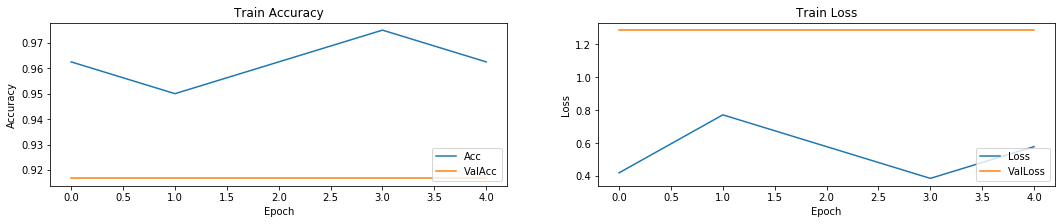

In [41]:
fig, ax = plt.subplots(1,2,figsize=(18,3))
ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Train Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Acc', 'ValAcc'], loc='lower right')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Train Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Loss', 'ValLoss'], loc='lower right')

In [ ]:
model.save('initial_model.h5')